<a href="https://colab.research.google.com/github/PhillipMas/PhillipMas/blob/main/GARCH_Finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!!pip install arch

['Requirement already satisfied: arch in /usr/local/lib/python3.10/dist-packages (7.0.0)',
 'Requirement already satisfied: numpy>=1.22.3 in /usr/local/lib/python3.10/dist-packages (from arch) (1.26.4)',
 'Requirement already satisfied: scipy>=1.8 in /usr/local/lib/python3.10/dist-packages (from arch) (1.13.1)',
 'Requirement already satisfied: pandas>=1.4 in /usr/local/lib/python3.10/dist-packages (from arch) (2.1.4)',
 'Requirement already satisfied: statsmodels>=0.12 in /usr/local/lib/python3.10/dist-packages (from arch) (0.14.2)',
 'Requirement already satisfied: python-dateutil>=2.8.2 in /usr/local/lib/python3.10/dist-packages (from pandas>=1.4->arch) (2.8.2)',
 'Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.10/dist-packages (from pandas>=1.4->arch) (2024.1)',
 'Requirement already satisfied: tzdata>=2022.1 in /usr/local/lib/python3.10/dist-packages (from pandas>=1.4->arch) (2024.1)',
 'Requirement already satisfied: patsy>=0.5.6 in /usr/local/lib/python3.1

In [85]:
import yfinance as yf
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm as norms


[*********************100%%**********************]  1 of 1 completed


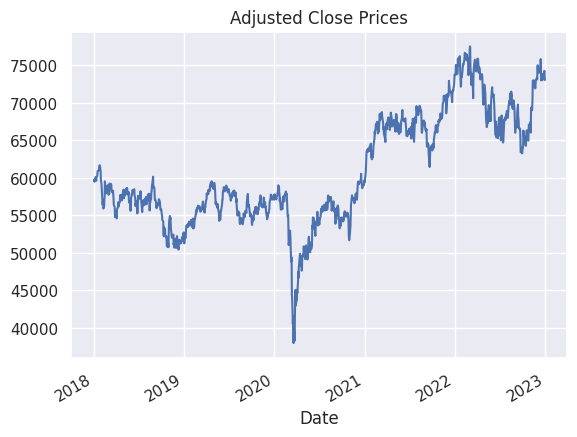

In [86]:
# Function to fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']

# Define parameters
ticker = '^J203.JO'
start_date = '2018-01-01'
end_date = '2022-12-31'

# Fetch the stock data
prices = fetch_stock_data(ticker, start_date, end_date)
prices.plot(title='Adjusted Close Prices')
plt.show()


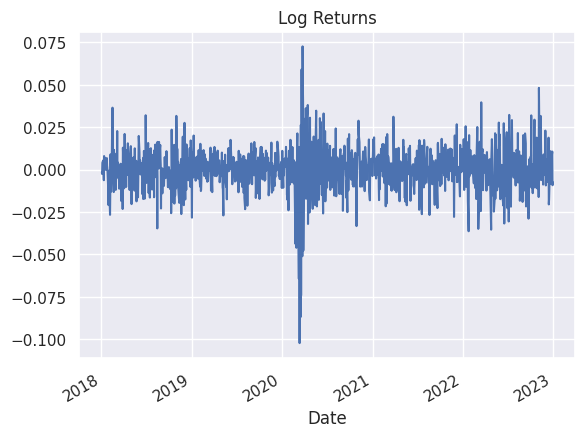

In [87]:
# Function to calculate returns
def calculate_returns(prices):
    returns = 1*(np.log(prices / prices.shift(1)).dropna())
    return returns

# Calculate the returns
returns = calculate_returns(prices)
returns.plot(title='Log Returns')
plt.show()


In [88]:

returns.max()

0.07261475087937772

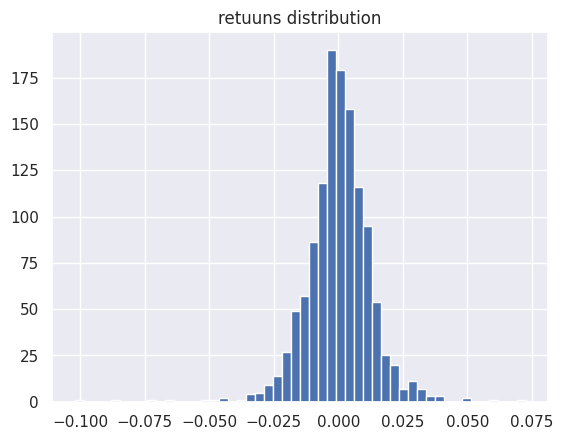

In [89]:
plt.hist(returns, bins = 50)
plt.title('retuuns distribution')
plt.show()

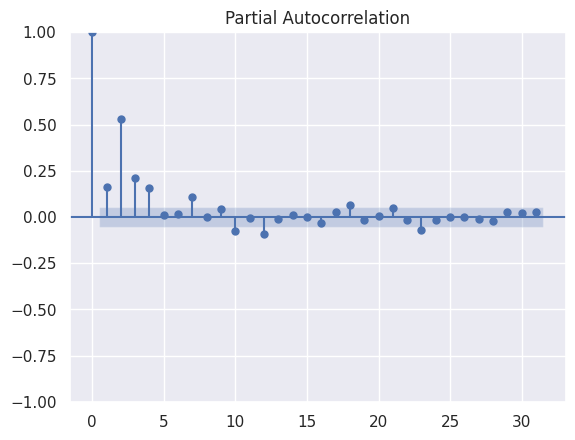

In [90]:
plot_pacf(returns**2)
plt.show()


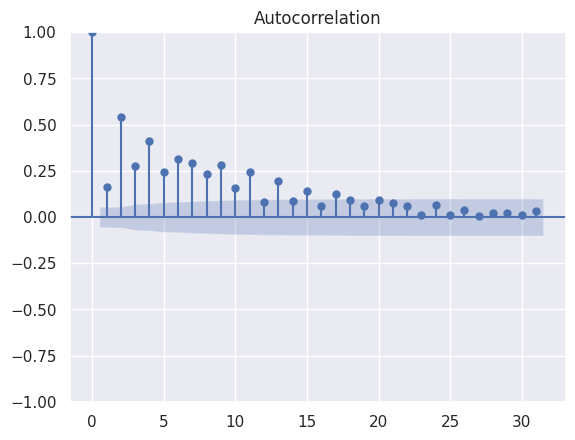

In [91]:
plot_acf(returns**2)
plt.show()


In [92]:
def var_historic(r, level=1):
    """
    Takes in a series of returns (r), and the percentage level
(level)
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

**Historical VaR**

In [93]:
import scipy.stats as stats
import statsmodels.tsa.api as smt_api
import statsmodels.graphics.tsaplots as smg
import statsmodels.stats.diagnostic as sms_diag
import seaborn as sns
sns.set()
import matplotlib.ticker as mtick

In [94]:
var_historic(returns,level=5)
print(f"90% Historical  VaR: {var_historic(returns,level=10)}")
print(f"95% Historical  VaR: {var_historic(returns,level=5)}")
print(f"99% Historical VaR: {var_historic(returns,level=1)}")


90% Historical  VaR: 0.01406545267594152
95% Historical  VaR: 0.01860497689809141
99% Historical VaR: 0.032689434944706476


**Now Parametric Using GarcH**

 **PAC plot ot determine the p and q of the garch**

In [95]:
from scipy.stats import norm

# Function to fit GARCH model and calculate VaR
def calculate_var(returns, mean="Zero", model_type='GARCH', dist='skewt',  p=2, q=2,rescale=True, var_level=0.05):
    if model_type == 'GARCH':
        model = arch_model(100*returns, vol='Garch',dist='skewt', p=p, q=q)
    elif model_type == 'EGARCH':
        model = arch_model(100*returns, vol='EGarch',dist='skewt', p=p, q=q)
    elif model_type == 'GJR-GARCH':
        model = arch_model(100*returns, vol='Garch',dist='skewt', p=p, q=q, o=1)
    else:
        raise ValueError("Unsupported model type. Use 'GARCH', 'EGARCH', or 'GJR-GARCH'.")


    model_fit = model.fit(disp='off')
    forecasts = model_fit.forecast(horizon=1)
    var_forecast = forecasts.variance[-1:].values[0,0]
    mean_return = forecasts.mean[-1:].values[0,0]
    z_score =norm.ppf( var_level)



    #var_value = np.sqrt(var_forecast) * np.percentile(returns, var_level *100)
    var_value = (np.sqrt(var_forecast) *z_score + mean_return)/100


    return var_value

# Calculate VaR using different GARCH model variants
var_garch = calculate_var(returns, model_type='GARCH')
var_egarch = calculate_var(returns, model_type='EGARCH')
var_gjr_garch = calculate_var(returns, model_type='GJR-GARCH')

print(f"GARCH VaR: {var_garch}")
print(f"EGARCH VaR: {var_egarch}")
print(f"GJR-GARCH VaR: {var_gjr_garch}")





GARCH VaR: -0.01718199766681352
EGARCH VaR: -0.018480283555552077
GJR-GARCH VaR: -0.018090494373782337


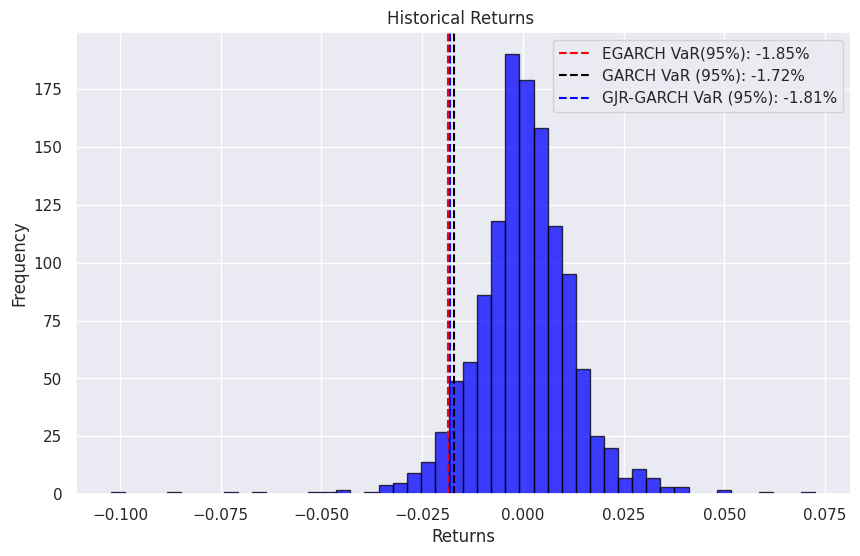

In [96]:
# Plot the historical returns and VaR threshold
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(var_egarch, color='red', linestyle='--', label=f'EGARCH VaR(95%): {var_egarch:.2%}')
plt.axvline(var_garch, color='black', linestyle='--', label=f'GARCH VaR (95%): {var_garch:.2%}')
plt.axvline(var_gjr_garch, color='blue', linestyle='--', label=f'GJR-GARCH VaR (95%): {var_gjr_garch:.2%}')
plt.title('Historical Returns ')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

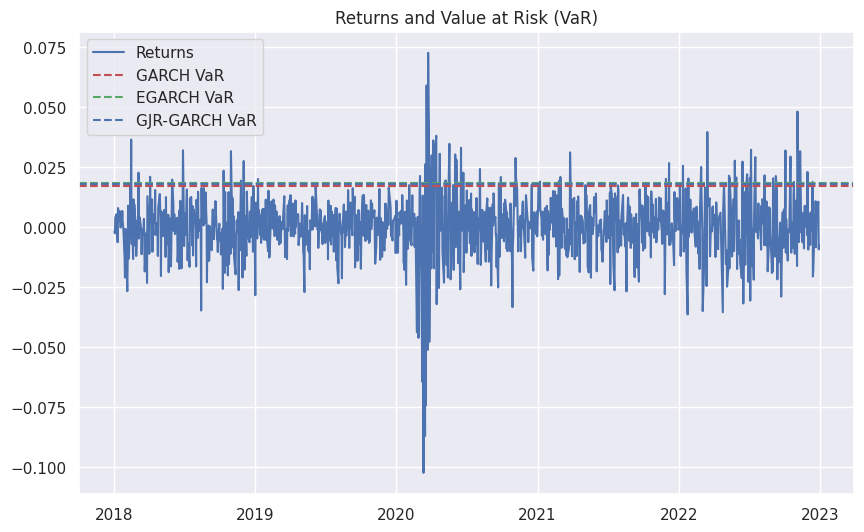

In [97]:
# Plot the returns and VaR
plt.figure(figsize=(10, 6))
plt.plot(returns, label='Returns')
plt.axhline(-var_garch, color='r', linestyle='--', label='GARCH VaR')
plt.axhline(-var_egarch, color='g', linestyle='--', label='EGARCH VaR')
plt.axhline(-var_gjr_garch, color='b', linestyle='--', label='GJR-GARCH VaR')
plt.legend()
plt.title('Returns and Value at Risk (VaR)')
plt.show()


#MODEL EVALUATION using
*  Akaike information criterion (AIC)
*   Bayesian information criterion(BIC)




This code calculates the AIC and BIC criteria, conducts backtesting and performs out-of-sample testing to assess the model’s efficacy.

In [98]:
 #Data preprocessing to remove NaN or infinite values
from arch import arch_model
import yfinance as yf
import numpy as np
import pandas as pd

data = yf.download(ticker, start=start_date, end=end_date)
# Calculate log returns
data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# Data preprocessing
returns = data['log_return'].dropna()



data = data.dropna()
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Define function for model evaluation GARCH
def evaluate_model(data):
    # Fit GARCH model
    am = arch_model(data['log_return'], mean='Zero', vol='Garch', p=3, q=3, rescale=True)
    res = am.fit(disp='off')

    # Calculate AIC and BIC
    aic = res.aic
    bic = res.bic

    # Perform backtesting
    residuals = data['log_return'] - res.conditional_volatility
    res_t = residuals / res.conditional_volatility
    backtest = (res_t**2).sum()

    # Out-of-sample testing
    data_length = len(data['log_return'])
    train_size = int(0.8 * data_length)
    train_data = data[:train_size]
    test_data = data[train_size:]

    res_oos = am.fit(last_obs=train_data.index[-1], disp='off')
    forecast = res_oos.forecast(start=train_data.index[-1], horizon=len(test_data))

    # Calculate out-of-sample forecast error
    forecast_vol = forecast.residual_variance.iloc[-1, :]
    error = (test_data['log_return'] - forecast_vol).dropna()

    return aic, bic, backtest, error

# Evaluate the GARCH model using log returns data
aic, bic, backtest, forecast_error = evaluate_model(data)

# Print the evaluation results
print(f'AIC: {aic}')
print(f'BIC: {bic}')
print(f'Backtesting Result: {backtest}')

[*********************100%%**********************]  1 of 1 completed


AIC: 3855.7081681530562
BIC: 3891.624459965131
Backtesting Result: 1249.9930252321858


In [99]:
# Define function for model evaluation GJR-GARCH
def evaluate_model(data):
    # Fit GARCH model
    am = arch_model(data['log_return'], mean='Zero', vol='Garch', p=3, q=3, o=1, rescale=True)
    res = am.fit(disp='off')

    # Calculate AIC and BIC
    aic = res.aic
    bic = res.bic

    # Perform backtesting
    residuals = data['log_return'] - res.conditional_volatility
    res_t = residuals / res.conditional_volatility
    backtest = (res_t**2).sum()

    # Out-of-sample testing
    data_length = len(data['log_return'])
    train_size = int(0.8 * data_length)
    train_data = data[:train_size]
    test_data = data[train_size:]

    res_oos = am.fit(last_obs=train_data.index[-1], disp='off')
    forecast = res_oos.forecast(start=train_data.index[-1], horizon=len(test_data))

    # Calculate out-of-sample forecast error
    forecast_vol = forecast.residual_variance.iloc[-1, :]
    error = (test_data['log_return'] - forecast_vol).dropna()

    return aic, bic, backtest, error

# Evaluate the GARCH model using log returns data
aic, bic, backtest, forecast_error = evaluate_model(data)

# Print the evaluation results
print(f'AIC: {aic}')
print(f'BIC: {bic}')
print(f'Backtesting Result: {backtest}')


AIC: 3808.4647579293623
BIC: 3849.5119485717332
Backtesting Result: 1249.989687891503


In [100]:
# Define function for model evaluation for EGARCH
def evaluate_model(data):
    # Fit GARCH model
    am=arch_model(data['log_return'],p = 1, q = 1, vol = 'EGARCH', dist = 't' ,rescale=True)
    res = am.fit(disp='off')

    # Calculate AIC and BIC
    aic = res.aic
    bic = res.bic

    # Perform backtesting
    residuals = data['log_return'] - res.conditional_volatility
    res_t = residuals / res.conditional_volatility
    backtest = (res_t**2).sum()

    # Out-of-sample testing
    data_length = len(data['log_return'])
    train_size = int(0.8 * data_length)
    train_data = data[:train_size]
    test_data = data[train_size:]

    res_oos = am.fit(last_obs=train_data.index[-1], disp='off')
    forecast = res_oos.forecast(start=train_data.index[-1], horizon=1)

    # Calculate out-of-sample forecast error
    forecast_vol = forecast.residual_variance.iloc[-1, :]
    error = (test_data['log_return'] - forecast_vol).dropna()

    return aic, bic, backtest, error

# Evaluate the GARCH model using log returns data
aic, bic, backtest, forecast_error = evaluate_model(data)

# Print the evaluation results
print(f'AIC: {aic}')
print(f'BIC: {bic}')
print(f'Backtesting Result: {backtest}')

AIC: 3814.6160523911753
BIC: 3840.270546542657
Backtesting Result: 1250.0705940961452
